In [3]:
# !pip install detecto

In [1]:
import glob
import numpy as np
import io


import torch
import torchvision
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
# from torchvision.models.detection import 

import skimage
from PIL import Image
from detecto.core import Model
from detecto.visualize import detect_live, detect_video, plot_prediction_grid, show_labeled_image
from detecto.core import DataLoader, Dataset
from detecto.utils import read_image, xml_to_csv, normalize_transform

import matplotlib.pyplot as plt

In [2]:
# model = Model()

In [3]:
# !du -sh /Users/haridas/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth

In [2]:
# detect_live(model)
train_dir = "/home/haridas/projects/mystique/data/train_and_test-2020-05-31/train"
test_dir = "/home/haridas/projects/mystique/data/train_and_test-2020-05-31/test"

In [3]:
# plot_prediction_grid
train_labels = xml_to_csv(
    train_dir,
    f"{train_dir}/../train_label.csv"
)
val_labels = xml_to_csv(
    test_dir,
    f"{test_dir}/../test_label.csv"
)

classes = train_labels['class'].unique().tolist()

In [4]:
train_labels["class"].value_counts()

textbox        922
image          258
radiobutton    108
actionset       67
checkbox        54
textboox        15
rating           3
Name: class, dtype: int64

In [81]:
# train_labels.filename.unique()
# !pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
normalize_transform()

Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [5]:
# Image reader and pre-processing pipeline.
transformer = T.Compose([
    T.ToPILImage(),
    lambda image: image.convert("RGB"),
    T.ToTensor(),
    normalize_transform()
])

In [73]:
# Pytorch dataset for train and validation.
dataset = Dataset(
    f"{train_dir}/../train_label.csv",
    image_folder=train_dir,
    transform=transformer
)

val_dataset = Dataset(
    f"{test_dir}/../test_label.csv",
    image_folder=test_dir,
    transform=transformer
)

In [74]:
train_dataloader = DataLoader(dataset, batch_size=2)
val_dataloader = DataLoader(val_dataset, batch_size=2)

In [71]:
# ims, lbs = dataset[100]
# show_labeled_image(ims, lbs["boxes"])

In [84]:
# !pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# torch.cuda("cuda:0")
# torch.cuda.is_available()
# f"{test_dir}/../train_label.csv"

## Train models in GPU

In [13]:
torch.cuda.device_count()

2

In [76]:
new_model = Model(classes)

In [80]:
# dataset._csv.describe()
# _model = torch.nn.DataParallel(new_model)

In [72]:
new_model.fit(dataset, val_dataset=val_dataset, verbose=True)

In [19]:
# new_model.save("pic2card_model.pth")
# !du -sh pic2card_model.pth

In [73]:
class CustomModel(Model):
    
    def __init__(self, classes=None, device=None, log_writer=None):
        self.log_writer = log_writer
        super(CustomModel, self).__init__(classes, device)
        
    def fit(self, dataset, val_dataset=None, epochs=10, learning_rate=0.0005, momentum=0.9,
        weight_decay=0.0005, gamma=0.1, lr_step_size=3, verbose=False):

        # If doing custom training, the given images will most likely be
        # normalized. This should fix the issue of poor performance on
        # default classes when normalizing, so resume normalizing. TODO
        if epochs > 0:
            self._disable_normalize = False

        # Convert dataset to data loader if not already
        if not isinstance(dataset, DataLoader):
            dataset = DataLoader(dataset, shuffle=True)

        if val_dataset is not None and not isinstance(val_dataset, DataLoader):
            val_dataset = DataLoader(val_dataset)

        losses = []
        # Get parameters that have grad turned on (i.e. parameters that should be trained)
        parameters = [p for p in self._model.parameters() if p.requires_grad]
        # Create an optimizer that uses SGD (stochastic gradient descent) to train the parameters
        optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        # Create a learning rate scheduler that decreases learning rate by gamma every lr_step_size epochs
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=gamma)

        # Train on the entire dataset for the specified number of times (epochs)
        for epoch in range(epochs):
            if verbose:
                print('Epoch {} of {}'.format(epoch + 1, epochs))

            # Training step
            avg_train_loss = 0.
            self._model.train()
            for images, targets in dataset:
                self._convert_to_int_labels(targets)
                images, targets = self._to_device(images, targets)

                # Calculate the model's loss (i.e. how well it does on the current
                # image and target, with a lower loss being better)
                loss_dict = self._model(images, targets)
                total_loss = sum(loss for loss in loss_dict.values())
                avg_train_loss += total_loss
                #print(f"Batch: {len(images)}, loss: {total_loss}")

                # Zero any old/existing gradients on the model's parameters
                optimizer.zero_grad()
                # Compute gradients for each parameter based on the current loss calculation
                total_loss.backward()
                # Update model parameters from gradients: param -= learning_rate * param.grad
                optimizer.step()
            
            avg_train_loss /= len(dataset)
            
            if verbose:
                print('Train Loss: {}'.format(avg_train_loss))
                self.log_writer.add_scalar("Loss/train", avg_train_loss, epoch)

            # Validation step
            if val_dataset is not None:
                avg_loss = 0
                with torch.no_grad():
                    for images, targets in dataset:
                        self._convert_to_int_labels(targets)
                        images, targets = self._to_device(images, targets)
                        loss_dict = self._model(images, targets)
                        total_loss = sum(loss for loss in loss_dict.values())
                        avg_loss += total_loss.item()

                avg_loss /= len(val_dataset.dataset)
                losses.append(avg_loss)

                if verbose:
                    print('Loss: {}'.format(avg_loss))
                    self.log_writer.add_scalar("Loss/val", avg_loss, epoch)

            # Update the learning rate every few epochs
            lr_scheduler.step()

        if len(losses) > 0:
            return losses

In [22]:
tb_writer = SummaryWriter("Second")
new_model = CustomModel(classes, log_writer=tb_writer)

In [ ]:
new_model.fit(train_dataloader, val_dataset=val_dataloader, verbose=True, epochs=20)

Epoch 1 of 10


/mnt1/haridas/projects/venv/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Loss: 1.0001208749241555
Epoch 2 of 10
Loss: 0.9212686431665833
Epoch 3 of 10


In [74]:
# model = Model(classes=["test", 'asdf'])
# model.predict([img])
# new_model.name
#save("/home/haridas/projects/pic2card/model/pth_models/")

In [75]:
# torch.cuda.memory_stats()
# model.predict([img])

In [10]:
# %debug

# Load saved model and test

In [9]:
model_path_20epoch = "/home/haridas/projects/pic2card/model/pth_models/faster-rcnn-2020-05-31-1590914103.pth",
model_path_25epoch = "/home/haridas/projects/pic2card/model/pth_models/faster-rcnn-2020-05-31-1590943544-epochs_25.pth"
# model_path_10epoch = "/home/haridas/projects/pic2card/model/pth_models/faster-rcnn-2020-05-31-1590928573-epochs_10.pth"

In [6]:
classes

['checkbox',
 'radiobutton',
 'textbox',
 'actionset',
 'image',
 'rating',
 'textboox']

In [45]:
# Load the saved model
model = Model.load("pic2card_model.pth", classes=classes)

In [10]:
model = Model.load(
    model_path_25epoch,
    classes=classes
)

In [33]:
img = transformer(read_image(f"{train_dir}/1.png"))

In [11]:
# show_labeled_image(
# T.ToPILImage(read_image(f"{train_dir}/1.png"))
# img.shape
im = read_image(f"{test_dir}/104.png")

In [16]:
type(im_tfs)

torch.Tensor

In [17]:
im = read_image(f"{test_dir}/104.png")
im_tfs = transformer(im)
labels, boxes, scores = model.predict([im_tfs])[0]
# show_labeled_image(im, boxes, labels)

/mnt1/haridas/projects/venv/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [32]:
# list(zip(labels, scores))
# model.predict([im_tfs])[0]
# np.array(classes)

IndexError: list index out of range

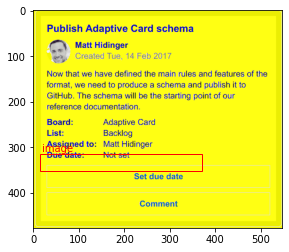

In [34]:
# labels, boxes, scores = model.predict(img)
# torchvision.transforms.ToPILImage()(img)
# show_labeled_image(img, boxes, labels)
# img.shape
show_labeled_image(img, boxes, labels=['image'])

In [79]:
# new_model._get_raw_predictions([img])
# Send the image to gpu.
# img = img.to(new_model._device)
# new_model._model([img])

In [ ]:
# model.predict([img])
# new_model.predict([img])

In [46]:
# !ls ../../mystique/data/train_and_test/train
# new_model._device
# %debug

# Tensorboard 

In [ ]:
from torch.utils.tensorboard import SummaryWriter, RecordWriter

In [ ]:
writer = SummaryWriter("testing")

In [ ]:
writer.add_image("images", torchvision.utils.make_grid([img]), 0)

In [ ]:
# writer.add_scalar?

In [ ]:
# writer.add_image?
writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)